# Hans 2024 data

Should probably formalize this as a Luigi or Airflow pipeline, but for now let's get everything set up interactively in notebooks so we can plot along the way.

## TODO:
1. ~~Fix inclusion of too short fragments in scoring, or allow it on purpose.~~

    Let's allow it on purpose - we can always filter the short fragments out later or even train multiple classifiers for different length ranges. I would like to be able to give a score for short fragments, even if it come with a caveat about reduced accuracy on shorter text. I just know people are going to want to use this thing on tweets...

2. Set longer length limit for Falcon, possibly using sequential device map or even CPU.
    
    Some complexity here - thinking maybe we should be using the 'auto' device map, it can handle longer sequences and works just as fast as a single K80, but that implies we have to keep loading and reloading the base and instruction tuned models. We could batch - do the reader calculations for a set of fragments and then switch models to do the writer calculations. Also, should probably set the length limit to ~1000 words. Given the length distribution of texts in the original dataset, that's pretty much the high end of the synthetic texts, but it's not very long for the human. Need to be careful how we sample lengths - want our length distributions to end up similar.
    
3. ~~Score both matched fragments from row in Hans data. More data is better!~~
4. ~~Shuffle data before train-test split such that training data is not mostly or all from the same sub-dataset.~~

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load and combine the scored text fragment data from the Hans 2024 corpus.

In [2]:
datasets = {
    # 'cc_news': 'cc_news-scores.json',
    # 'pubmed': 'pubmed-scores.json',
    # 'cnn': 'cnn-scores.json'
    'falcon': 'falcon-7b_scores.json'
}

dataframes = []

for dataset, filename in datasets.items():

    print(f'\nRaw {dataset} dataset:')

    dataframe = pd.read_json(f'{config.HANS_DATA_PATH}/{filename}')

    # Replace and remove string 'OOM' and 'NAN' values
    dataframe.replace('NAN', np.nan, inplace = True)
    dataframe.replace('OOM', np.nan, inplace = True)
    dataframe.dropna(inplace = True)

    # Update name of score column, some earlier runs called
    # it by the old names
    dataframe.rename(columns = {
        'Binoculars score': 'Perplexity ratio score',
        'Observer peak memory (GB)': 'Reader peak memory (GB)',
        'Performer peak memory (GB)': 'Writer peak memory (GB)'
    }, inplace = True)

    dataframe.info()

    # Fix some d-types
    dataframe = dataframe.astype({
        'Fragment': int,
        'Fragment length (tokens)': int,
        'Reader peak memory (GB)': float,
        'Writer peak memory (GB)': float,
        'Perplexity': float,
        'Cross-perplexity': float,
        'Perplexity ratio score': float
    })

    # get rid of some unnecessary columns
    dataframe.drop([
        'Fragment', 
        'Reader peak memory (GB)', 
        'Writer peak memory (GB)'
    ], axis = 1, inplace = True)

    dataframes.append(dataframe)

# Combine the individual datasets
data_df = pd.concat(dataframes, axis = 0)

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

print('\nCombined dataset:')
data_df.info()


Raw falcon dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 105055 entries, 0 to 105080
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Fragment                  105055 non-null  int64  
 1   Fragment length (tokens)  105055 non-null  object 
 2   Dataset                   105055 non-null  object 
 3   Source                    105055 non-null  object 
 4   String                    105055 non-null  object 
 5   Reader peak memory (GB)   105055 non-null  float64
 6   Writer peak memory (GB)   105055 non-null  float64
 7   Perplexity                105055 non-null  object 
 8   Cross-perplexity          105055 non-null  object 
 9   Perplexity ratio score    105055 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 8.8+ MB

Combined dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105055 entries, 0 to 105054
Data columns (total 7 columns):
 #   Colum

Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 77919 human text fragments and 27136 synthetic fragments.
Dataset is 25.8% synthetic fragments.


In [4]:
data_df.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
0,144,cnn-llama2-13,human,Kuchar ground out a level-par 72 that he descr...,2.373,2.345703,1.011657
1,206,cc_news-llama2-13,human,The atmosphere is designed to evoke the feelin...,2.582,2.400391,1.075671
2,170,cc_news-falcon7,human,by Rob Lever Facebook shares plunged Monday as...,2.447,2.396484,1.021190
3,90,cnn-falcon7,synthetic,his home.\n“We are waiting for the results of...,2.299,2.839844,0.809491
4,288,cc_news-llama2-13,human,or as an insurance deduction. Some people who ...,2.893,2.888672,1.001352


In [5]:
data_df.tail()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
105050,160,pubmed-llama2-13,human,in 2 or more macrophages try to ingest same pa...,2.7420,2.771484,0.989429
105051,135,cnn-llama2-13,human,"capable of doing it. He thinks, ""You're paying...",3.6200,3.246094,1.114922
105052,112,cnn-falcon7,synthetic,to carry out his or her own agenda. This was a...,2.6500,3.457031,0.766667
105053,493,pubmed-llama2-13,synthetic,"21 ( figure 1, 2 ). a 49-year - old male prese...",1.9830,2.246094,0.883043
105054,376,cnn-llama2-13,human,"billion . 4. Amancio Ortega - Zara, $64.5 bill...",1.1455,1.250000,0.916406


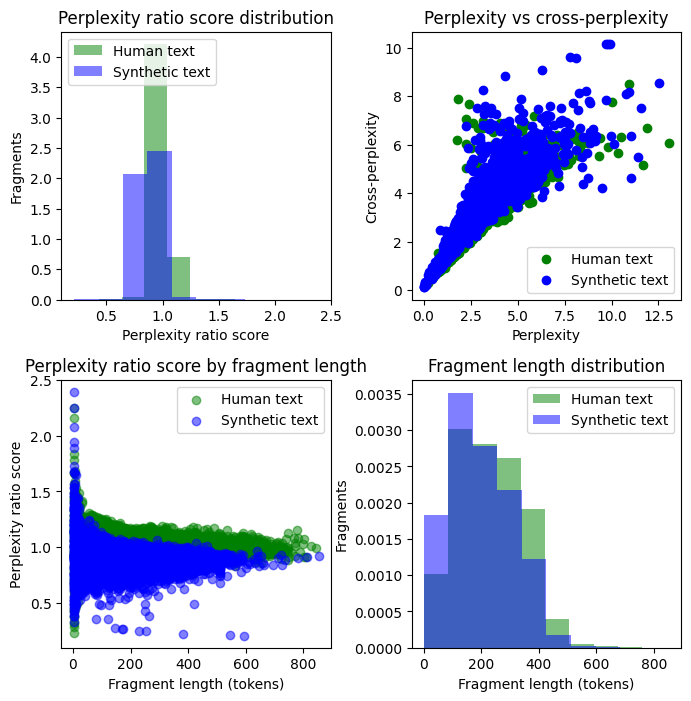

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Something strange in the fragment length vs perplexity ratio score plot - the minimum fragment length should be 50 words? Not sure what is going on... let's take a closer look.

In [7]:
short_fragments = human_fragments[human_fragments['Fragment length (tokens)'] < 10]
short_fragments.head()

,Fragment length (tokens),Dataset,Source,String,Perplexity,Cross-perplexity,Perplexity ratio score
542,9,cc_news-llama2-13,human,"and Co, this is only the beginning.",4.230,5.109375,0.827982
1625,7,cnn-llama2-13,human,of acquittal and new trial.,4.670,5.152344,0.906748
2295,9,cnn-llama2-13,human,and an assortment of ill fitting hats .,5.074,4.394531,1.154667
2913,8,cnn-llama2-13,human,"not in my country, not anywhere.",4.008,5.121094,0.782609
3542,8,cnn-llama2-13,human,skinny jeans and high heels .,3.053,5.054688,0.603941


Yeah, looks like we have some weird stuff - apparently the extra ends of sentences get used? This could be a problem with how we did the sampling from the larger blocks of text contained in the Hans corpus. We don't have time to go back and fix it, but we can prevent those scores from being carried forward at this step. Let's threshold the length before we save.

Yeah, side note, found it. From perplexity_ratio.py in the benchmarking functions (line 147):

```text
    # If the slice length is greater than the
    # length of the input tokens, use all of
    # them
    if slice_length > total_length:
        slice_length = total_length
```

Also, bad terminological specificity here - we are actually talking about words.... not tokens.

In [8]:
data_df = data_df[data_df['Fragment length (tokens)'] > 50]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

OK - plot again just for sanity check.

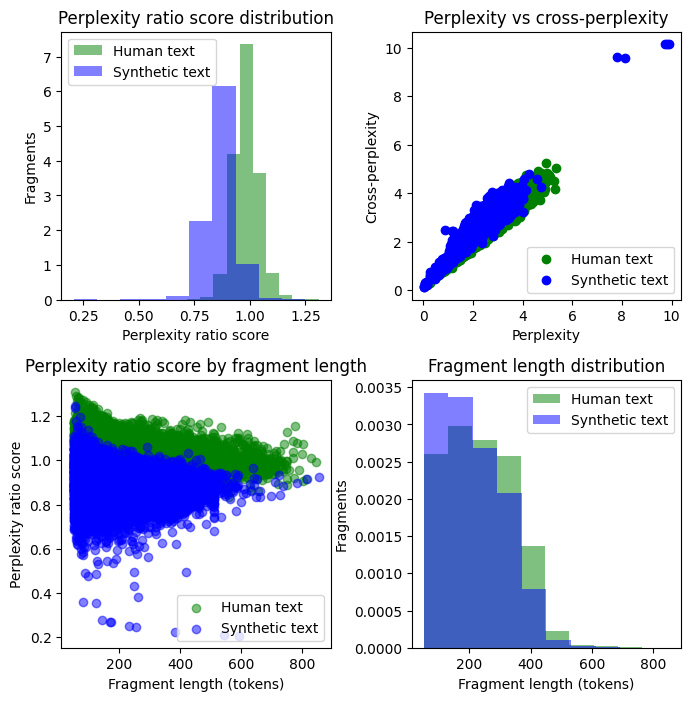

In [9]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'lower right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

OK, good, looks good, actually much better. Let's clip those high outliers on the perplexity/cross perplexity plot.

In [10]:
data_df = data_df[(data_df['Perplexity'] < 6) & (data_df['Cross-perplexity'] < 6)]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

In [11]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA

with open(output_file, 'w') as file:
    file.write(data_df.to_json())

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [12]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 81310 training examples
Have 20328 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20328 entries, 0 to 20327
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fragment length (tokens)  20328 non-null  int64  
 1   Dataset                   20328 non-null  object 
 2   Source                    20328 non-null  object 
 3   String                    20328 non-null  object 
 4   Perplexity                20328 non-null  float64
 5   Cross-perplexity          20328 non-null  float64
 6   Perplexity ratio score    20328 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.1+ MB


And finally, save the split data for future use.

In [13]:
# Save testing data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())